Task 1.1
Reading in the dataset from https://www.kaggle.com/puneet6060/intel-image-classification and using a convolution base to classify the images within.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import PIL
import PIL.Image
import pathlib
from tensorflow.keras.optimizers import RMSprop

Here we visualize the data. There are 6 different classes in this dataset of locations: buildings, forest, glacier, mountain, sea, and street. An example of each is shown below. There is not an equal number of each class, though they have very similar amounts so I don't anticipate this throwing off the model.

Number of Buildings: 2190
Number of Forest: 2271
Number of Glacier: 2404
Number of Mountain: 2512
Number of Sea: 2274
Number of Street: 2382


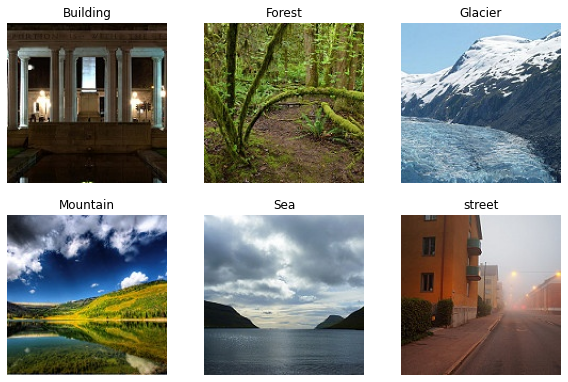

In [2]:
batch_size = 10
img_h = img_w = 150

data_dir = pathlib.Path('./seg_train/seg_train')

buildings = list(data_dir.glob('buildings/*'))
forest = list(data_dir.glob('forest/*'))
glacier = list(data_dir.glob('glacier/*'))
mountain = list(data_dir.glob('mountain/*'))
sea = list(data_dir.glob('sea/*'))
street = list(data_dir.glob('street/*'))

plt.figure(figsize=(10, 10))

ax = plt.subplot(3, 3, 1)
plt.imshow(PIL.Image.open(str(buildings[0])))
plt.title("Building")
plt.axis("off")

ax = plt.subplot(3, 3, 2)
plt.imshow(PIL.Image.open(str(forest[0])))
plt.title("Forest")
plt.axis("off")

ax = plt.subplot(3, 3, 3)
plt.imshow(PIL.Image.open(str(glacier[0])))
plt.title("Glacier")
plt.axis("off")

ax = plt.subplot(3, 3, 4)
plt.imshow(PIL.Image.open(str(mountain[0])))
plt.title("Mountain")
plt.axis("off")

ax = plt.subplot(3, 3, 5)
plt.imshow(PIL.Image.open(str(sea[0])))
plt.title("Sea")
plt.axis("off")

ax = plt.subplot(3, 3, 6)
plt.imshow(PIL.Image.open(str(street[0])))
plt.title("street")
plt.axis("off")

print("Number of Buildings:", len(buildings))
print("Number of Forest:", len(forest))
print("Number of Glacier:", len(glacier))
print("Number of Mountain:", len(mountain))
print("Number of Sea:", len(sea))
print("Number of Street:", len(street))

Here we split the dataset into Train-Dev-Test.

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="training",
  seed=456,
  image_size=(img_h, img_w),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.30,
  subset="validation",
  seed=456,
  image_size=(img_h, img_w),
  batch_size=batch_size)

test_ds = val_ds.take(40)
dev_ds = val_ds.skip(40)

Found 14033 files belonging to 6 classes.
Using 9824 files for training.


2021-10-28 03:08:38.957066: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 14033 files belonging to 6 classes.
Using 4209 files for validation.


Standardize RGB channel to be [0,1] instead of [0,255], for grayscale. Tuning data with tensorflow.

In [4]:
class_names = val_ds.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
dev_ds = dev_ds.cache().prefetch(buffer_size=AUTOTUNE)

Here the model is defined and trained. It has only one convolution layer because the complexity of this image classification is not super high, so it is unlikely that the model would get a lot of benefit from additional layers. I also opted to use average pooling because the images do not tend to focus on a brighter or darker object, but instead take in an entire scene.

In [5]:
num_classes = 6
model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['acc'])

model.fit(
  train_ds,
  validation_data=dev_ds,
  batch_size = 10,
  epochs=10
)

Epoch 1/10


/home/nick/.local/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2021-10-28 03:08:49.974939: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


983/983 [==============================] - 311s 290ms/step - loss: 1.0872 - acc: 0.5934 - val_loss: 0.8265 - val_acc: 0.7036
Epoch 2/10
983/983 [==============================] - 146s 148ms/step - loss: 0.7203 - acc: 0.7487 - val_loss: 0.7375 - val_acc: 0.7472
Epoch 3/10
983/983 [==============================] - 148s 151ms/step - loss: 0.5353 - acc: 0.8287 - val_loss: 0.7055 - val_acc: 0.7619
Epoch 4/10
983/983 [==============================] - 150s 152ms/step - loss: 0.4006 - acc: 0.8795 - val_loss: 0.7190 - val_acc: 0.7603
Epoch 5/10
983/983 [==============================] - 142s 144ms/step - loss: 0.2999 - acc: 0.9152 - val_loss: 0.7525 - val_acc: 0.7558
Epoch 6/10
983/983 [==============================] - 140s 143ms/step - loss: 0.2222 - acc: 0.9405 - val_loss: 0.8202 - val_acc: 0.7409
Epoch 7/10
983/983 [==============================] - 131s 133ms/step - loss: 0.1637 - acc: 0.9596 - val_loss: 0.9144 - val_acc: 0.7280
Epoch 8/10
983/983 [==============================] - 133s 

The model accuracy measurment is based on how many classifications it is able to get correct. Here I also test it on the test dataset.

In [6]:
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])
    
labels = list(map(lambda x: x[1], test_ds))
lis = []
#getting true labels
for i in range(0, 40):
    for z in range(0, 10):
        lis.append(tf.get_static_value(list(labels[i])[z]))

average = 0
correct = 0
for i in range(0, 400):
  score = tf.nn.softmax(predictions[i])
  average += 100 * np.max(score)
  if np.argmax(score) == lis[i]:
    correct += 1
  if  i % 20 == 0:
      print(
        "This image is most likely a {} with a {:.2f} confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

print("Predicted confidence average:")
print(str(average / 400) + "%")
print("Percent of guesses that are correct:")
print(str(correct / 4) + "%")

This image is most likely a glacier with a 84.34 confidence.
This image is most likely a sea with a 70.99 confidence.
This image is most likely a sea with a 46.56 confidence.
This image is most likely a street with a 45.05 confidence.
This image is most likely a mountain with a 76.28 confidence.
This image is most likely a sea with a 70.56 confidence.
This image is most likely a sea with a 54.60 confidence.
This image is most likely a forest with a 100.00 confidence.
This image is most likely a sea with a 79.90 confidence.
This image is most likely a mountain with a 89.67 confidence.
This image is most likely a glacier with a 98.96 confidence.
This image is most likely a sea with a 61.06 confidence.
This image is most likely a mountain with a 93.57 confidence.
This image is most likely a street with a 99.87 confidence.
This image is most likely a glacier with a 71.62 confidence.
This image is most likely a street with a 93.77 confidence.
This image is most likely a sea with a 50.41 con

Task 1.2
Here we load the Inception_v3 model with tensorflow and evaluate it the same way we did with my model. We need to change the shape to match our images. In order to do this include_top must be set to false. We also use the default imagenet weights.

To train the model on this data the layers must be set to false, the layer is flattened to one output, a fully connected layer is added, and a final logistic layer with 6 classes specified. Then it is compiled witht he same method as the first model and fit to the same data.

In [7]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = 'imagenet')

for layer in pre_trained_model.layers:
  layer.trainable = False

x = tf.keras.layers.Flatten()(pre_trained_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)                 
x = tf.keras.layers.Dense  (6, activation='sigmoid')(x)           

model_p1 = tf.keras.Model( pre_trained_model.input, x) 

model_p1.compile(optimizer = RMSprop(lr=0.0001), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['acc'])

model_p1.fit(
  train_ds,
  validation_data=dev_ds,
  batch_size = 10,
  epochs=10
)

Epoch 1/10


/home/nick/.local/lib/python3.8/site-packages/keras/backend.py:4906: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


983/983 [==============================] - 219s 219ms/step - loss: 31.2381 - acc: 0.4378 - val_loss: 17.4905 - val_acc: 0.4844
Epoch 2/10
983/983 [==============================] - 217s 220ms/step - loss: 15.2991 - acc: 0.5100 - val_loss: 12.7919 - val_acc: 0.4891
Epoch 3/10
983/983 [==============================] - 219s 222ms/step - loss: 13.5066 - acc: 0.5525 - val_loss: 15.2395 - val_acc: 0.4925
Epoch 4/10
983/983 [==============================] - 225s 229ms/step - loss: 12.3119 - acc: 0.5700 - val_loss: 19.8568 - val_acc: 0.4237
Epoch 5/10
983/983 [==============================] - 216s 220ms/step - loss: 11.1018 - acc: 0.5886 - val_loss: 15.6384 - val_acc: 0.5306
Epoch 6/10
983/983 [==============================] - 229s 233ms/step - loss: 10.5050 - acc: 0.6056 - val_loss: 22.5755 - val_acc: 0.4269
Epoch 7/10
983/983 [==============================] - 223s 227ms/step - loss: 10.0395 - acc: 0.6111 - val_loss: 14.8100 - val_acc: 0.5311
Epoch 8/10
983/983 [=========================

This model has a less consistent curve then the original, having a tendency to get massivly reduced accuracy from one epoch to the other, especially when concerning the validation accuracy. I think that the added complexity of this model paired with the relative simplicty of my problem has made it perform this way. 

While testing I originally used SGD as the optimizer for both models and found that, while the first model performed fine, this one only had about 30% accuracy so I switched to RMSprop instead. RMSprop has about doubled the accuracy on this second model, and also improved the first model from about 60% to 98% accuracy aswell. 

That being said this accuracy measure is on the training set, and both models perform a little worse on the test and dev sets. The desync between the two metrics starts as early as the second epoch, hopefully data augmentation will help here.

There is definitly some overfitting. In order to help mitigate this I also lowered the number of epochs down to 10.

Here we again verify the accuracy based on the test set. Overall the accuracy is slightly worse, I think this is due to the complexity of the model vs the complexity of the problem.

In [8]:
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])

average = 0
correct = 0
for i in range(0, 400):
  score = tf.nn.softmax(predictions[i])
  average += 100 * np.max(score)
  if np.argmax(score) == lis[i]:
    correct += 1
  if  i % 20 == 0:
      print(
        "This image is most likely a {} with a {:.2f} confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

print("Predicted confidence average:")
print(str(average / 400) + "%")
print("Percent of guesses that are correct:")
print(str(correct / 4) + "%")

This image is most likely a glacier with a 84.34 confidence.
This image is most likely a sea with a 70.99 confidence.
This image is most likely a sea with a 46.56 confidence.
This image is most likely a street with a 45.05 confidence.
This image is most likely a mountain with a 76.28 confidence.
This image is most likely a sea with a 70.56 confidence.
This image is most likely a sea with a 54.60 confidence.
This image is most likely a forest with a 100.00 confidence.
This image is most likely a sea with a 79.90 confidence.
This image is most likely a mountain with a 89.67 confidence.
This image is most likely a glacier with a 98.96 confidence.
This image is most likely a sea with a 61.06 confidence.
This image is most likely a mountain with a 93.57 confidence.
This image is most likely a street with a 99.87 confidence.
This image is most likely a glacier with a 71.62 confidence.
This image is most likely a street with a 93.77 confidence.
This image is most likely a sea with a 50.41 con

Task 1.3:
Here we augment the data and attempt to train again with the model from part 1.
The augmentations being used are flipping the images, rotating them, and zooming in a random amount.

In [9]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(150, 150, 3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
  ]
)

Here is visualization for what this would look like.

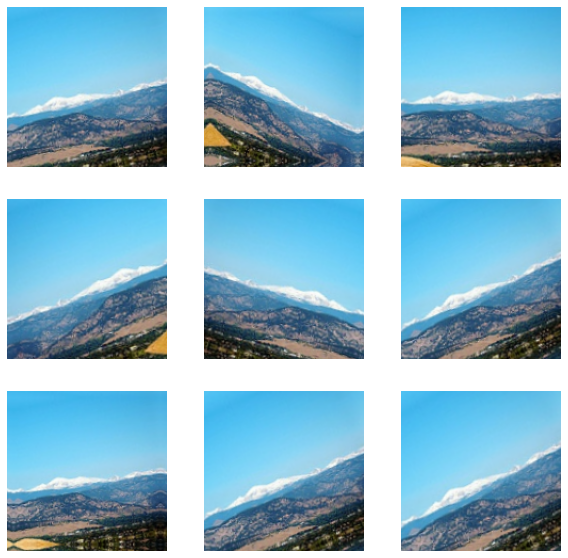

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Training on the same model as in part 1, but with the data augmentation performed at the start.

In [11]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.AveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['acc'])

model.fit(
  train_ds,
  validation_data=dev_ds,
  batch_size = 10,
  epochs=10
)

Epoch 1/10
983/983 [==============================] - 150s 152ms/step - loss: 1.2807 - acc: 0.5134 - val_loss: 1.0901 - val_acc: 0.6036
Epoch 2/10
983/983 [==============================] - 141s 144ms/step - loss: 0.9988 - acc: 0.6301 - val_loss: 1.0413 - val_acc: 0.6466
Epoch 3/10
983/983 [==============================] - 146s 149ms/step - loss: 0.9198 - acc: 0.6586 - val_loss: 1.0372 - val_acc: 0.6550
Epoch 4/10
983/983 [==============================] - 144s 147ms/step - loss: 0.8733 - acc: 0.6829 - val_loss: 1.0275 - val_acc: 0.6705
Epoch 5/10
983/983 [==============================] - 143s 146ms/step - loss: 0.8369 - acc: 0.6982 - val_loss: 0.9584 - val_acc: 0.6871
Epoch 6/10
983/983 [==============================] - 144s 147ms/step - loss: 0.8082 - acc: 0.7068 - val_loss: 0.9599 - val_acc: 0.6918
Epoch 7/10
983/983 [==============================] - 143s 146ms/step - loss: 0.7931 - acc: 0.7128 - val_loss: 0.9459 - val_acc: 0.7062
Epoch 8/10
983/983 [============================

After the same amount of epochs the stated accuracy is lower, but the training accuracy and validation accuracy are more closely matched so I belive that this is better overall. If I gave it a little more time to train I think it would reach the same validation accuracy of the first model, but be less overfitted.

In [12]:
predictions = model.predict(test_ds)
score = tf.nn.softmax(predictions[0])

average = 0
correct = 0
for i in range(0, 400):
  score = tf.nn.softmax(predictions[i])
  average += 100 * np.max(score)
  if np.argmax(score) == lis[i]:
    correct += 1
  if  i % 20 == 0:
      print(
        "This image is most likely a {} with a {:.2f} confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score)))

print("Predicted confidence average:")
print(str(average / 400) + "%")
print("Percent of guesses that are correct:")
print(str(correct / 4) + "%")

This image is most likely a mountain with a 46.51 confidence.
This image is most likely a sea with a 48.69 confidence.
This image is most likely a buildings with a 84.08 confidence.
This image is most likely a buildings with a 52.11 confidence.
This image is most likely a buildings with a 94.39 confidence.
This image is most likely a mountain with a 79.19 confidence.
This image is most likely a mountain with a 44.47 confidence.
This image is most likely a forest with a 99.97 confidence.
This image is most likely a sea with a 69.72 confidence.
This image is most likely a mountain with a 97.13 confidence.
This image is most likely a glacier with a 41.58 confidence.
This image is most likely a buildings with a 92.68 confidence.
This image is most likely a mountain with a 82.43 confidence.
This image is most likely a street with a 99.86 confidence.
This image is most likely a sea with a 43.36 confidence.
This image is most likely a forest with a 53.49 confidence.
This image is most likely 

The model definitly benefits from the data augmentation, it reduces the overfitting, improving the accuracy on items outside the training set.